In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import logging
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from imblearn.under_sampling import RandomUnderSampler

# Suppress warnings
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# --- 0. Load and Prepare Dataset ---
df = pd.read_csv('modern_slavery_NER_us_india_val1.csv', index_col=0)
df = df.drop_duplicates().reset_index(drop=True)

# Clean content
def get_only_words_from_strings(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return re.sub(r'\d+', '', text).strip()

df['content'] = df['content'].apply(get_only_words_from_strings)
df = df[['content', 'modern_slavery_in_supply_chain']].dropna()

# Encode target
def classify(row):
    return 1 if str(row).strip().lower() == 'yes' else 0

df['target'] = df['modern_slavery_in_supply_chain'].apply(classify)
df = df[['content', 'target']]

# --- 1. Prepare Texts and Labels ---
texts = df['content'].tolist()
labels = df['target'].values

if isinstance(labels[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_)
else:
    y = labels.astype(int)
    num_classes = len(np.unique(y))

is_binary = num_classes == 2

# --- 2. Tokenize with RoBERTa ---
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

encodings = tokenizer(
    texts,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

input_ids = encodings['input_ids'].numpy()
attention_mask = encodings['attention_mask'].numpy()

# --- 3. Train-Test Split ---
X_train_ids, X_test_ids, y_train, y_test = train_test_split(
    input_ids, y,
    test_size=0.2,
    random_state=42,
    stratify=y if num_classes > 1 else None
)

X_train_mask, X_test_mask, _, _ = train_test_split(
    attention_mask, y,
    test_size=0.2,
    random_state=42,
)

# --- 4. Undersampling ---
rus = RandomUnderSampler(random_state=42)
train_indices = np.arange(X_train_ids.shape[0])
resampled_indices, y_train_resampled = rus.fit_resample(train_indices.reshape(-1, 1), y_train)

X_train_ids = X_train_ids[resampled_indices.flatten()]
X_train_mask = X_train_mask[resampled_indices.flatten()]
y_train = y_train_resampled

# --- 5. Load RoBERTa Pretrained Model ---
model = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# --- 6. Compile Model ---
optimizer = Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- 7. Prepare Datasets ---
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': X_train_ids, 'attention_mask': X_train_mask}, y_train)
).shuffle(1000).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ({'input_ids': X_test_ids, 'attention_mask': X_test_mask}, y_test)
).batch(16)

# --- 8. EarlyStopping Callback ---
early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=500,
    restore_best_weights=True,
    verbose=1
)

# --- 9. Fine-tune the Model ---
print("\nStarting Fine-tuning RoBERTa...")
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=1000,
    callbacks=[early_stop],
    verbose=1
)
print("Fine-tuning Finished.")

# --- 10. Evaluation ---
results = model.evaluate(test_dataset, verbose=0)
acc = results[1]

predictions = model.predict(test_dataset)
y_pred_logits = predictions.logits
y_pred = np.argmax(y_pred_logits, axis=1)

prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted', zero_division=0
)

# --- 11. Store Results ---
model_display_name = f'RoBERTa (base) undersampled'
final_results = {
    'Model': model_display_name,
    'Accuracy': round(acc * 100, 4),
    'Precision': round(prec * 100, 4),
    'Recall': round(rec * 100, 4),
    'F1 Score': round(f1 * 100, 4),
}

# Save results
if 'test_result' not in locals():
    test_result = pd.DataFrame()

test_result = pd.concat([test_result, pd.DataFrame([final_results])], ignore_index=True)

print("\nUpdated Test Results DataFrame:")
print(test_result)

# --- 12. Save Fine-tuned Model and Tokenizer ---
save_directory = "./roberta_classifier_finetuned"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"\nModel and tokenizer saved to {save_directory}")


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import logging
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import classification_report

# --- Setup ---
save_directory = "./roberta_classifier_finetuned"
tokenizer = RobertaTokenizer.from_pretrained(save_directory)
model = TFRobertaForSequenceClassification.from_pretrained(save_directory)

# --- Load and Clean Test Data ---
df_new = pd.read_csv("teste_subset.csv")

# Optional cleaning if needed
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = re.sub(r'\s+', ' ', text).strip()
    return re.sub(r'\d+', '', text).strip()

df_new['content_corrected'] = df_new['content_corrected'].apply(clean_text)

# --- Tokenize ---
texts_new = df_new['content_corrected'].tolist()

encodings_new = tokenizer(
    texts_new,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_new_ids = encodings_new['input_ids']
X_new_mask = encodings_new['attention_mask']

new_dataset = tf.data.Dataset.from_tensor_slices(
    {'input_ids': X_new_ids, 'attention_mask': X_new_mask}
).batch(16)

# --- Predict ---
predictions = model.predict(new_dataset)
logits = predictions.logits
y_pred = np.argmax(logits, axis=1)

# --- Evaluate ---
df_new['predicted'] = y_pred
df_new['true'] = df_new['target']

for source in df_new['source'].unique():
    print(f"\n--- Performance for source: {source} ---")
    subset = df_new[df_new['source'] == source]
    report = classification_report(
        subset['true'],
        subset['predicted'],
        target_names=['no', 'yes'],
        output_dict=True
    )

    weighted = report['weighted avg']
    accuracy = report['accuracy']

    print("Weighted Avg:")
    print(f"  Precision : {weighted['precision']:.4f}")
    print(f"  Recall    : {weighted['recall']:.4f}")
    print(f"  F1-score  : {weighted['f1-score']:.4f}")
    print(f"  Support   : {weighted['support']}")
    print(f"Accuracy    : {accuracy:.4f}")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./roberta_classifier_finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


27/27 [==============================] - 31s 717ms/step

--- Performance for source: IndiaLII ---
              precision    recall  f1-score   support

          no       0.88      0.99      0.93        73
         yes       0.92      0.55      0.69        22

    accuracy                           0.88        95
   macro avg       0.90      0.77      0.81        95
weighted avg       0.89      0.88      0.87        95


--- Performance for source: Courtlistener ---
              precision    recall  f1-score   support

          no       0.89      0.99      0.94       295
         yes       0.50      0.10      0.17        40

    accuracy                           0.88       335
   macro avg       0.69      0.54      0.55       335
weighted avg       0.84      0.88      0.84       335




--- Performance for source: IndiaLII ---
Weighted Avg:
  Precision : 0.8885
  Recall    : 0.8842
  F1-score  : 0.8727
  Support   : 95.0
Accuracy    : 0.8842

--- Performance for source: Courtlistener ---
Weighted Avg:
  Precision : 0.8434
  Recall    : 0.8806
  F1-score  : 0.8439
  Support   : 335.0
Accuracy    : 0.8806


c:\Users\Jaque\anaconda3\envs\transformers\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dados de teste recriados com sucesso.




All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Modelo e tokenizer carregados do diretório salvo.
27/27 [==============================] - 45s 2s/step

Expected Calibration Error (ECE) com 15 bins: 6.07%


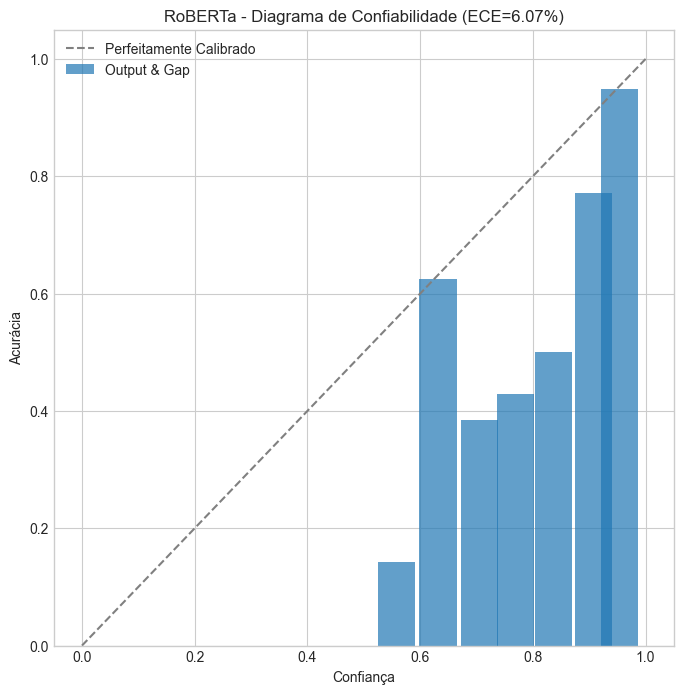

In [1]:
#ECE

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Configurações (as mesmas do seu código original) ---
MODEL_NAME = "roberta-base"
MAX_LEN = 256
BATCH_SIZE = 16
SEED = 42
M = 15  # Número de bins, como usado no artigo 

# --- 1. Carregar e Pré-processar os Dados (Recriar o conjunto de teste) ---
try:
    df = pd.read_csv('D:/Users/Jaque/Downloads/modern_slavery_NER_us_india_val1.csv', index_col=0)
    df = df.drop_duplicates().reset_index(drop=True)
    
    def get_only_words_from_strings(text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return re.sub(r'\d+', '', text).strip()

    df['content_corrected'] = df['content_corrected'].apply(get_only_words_from_strings)
    df = df[['content_corrected', 'modern_slavery_in_supply_chain']].dropna()
    df['target'] = df['modern_slavery_in_supply_chain'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
    
    texts = df['content_corrected'].tolist()
    labels = df['target'].tolist()
    
    _, test_texts, _, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=SEED)
    
    print("Dados de teste recriados com sucesso.")

except FileNotFoundError:
    print("Erro: Verifique se o arquivo 'C:/Users/Jaque/Downloads/modern_slavery_NER_us_india_val1.csv' existe.")
    exit()

# --- 2. Carregar o modelo e o tokenizer salvos ---
save_directory = "./"
try:
    tokenizer = AutoTokenizer.from_pretrained(save_directory)
    model = TFAutoModelForSequenceClassification.from_pretrained(save_directory)
    print("Modelo e tokenizer carregados do diretório salvo.")
except FileNotFoundError:
    print(f"Erro: O diretório '{save_directory}' não foi encontrado. Verifique se o modelo foi salvo corretamente.")
    exit()

# --- 3. Tokenizar os dados de teste e criar o Dataset ---
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors='tf')
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(BATCH_SIZE)

# --- 4. Obter as previsões e probabilidades ---
predictions = model.predict(test_dataset)
y_pred_logits = predictions.logits
y_pred_proba = tf.nn.softmax(y_pred_logits, axis=1).numpy()

# A confiança é a probabilidade da classe prevista [cite: 51]
y_pred = np.argmax(y_pred_logits, axis=1)
confidence = np.max(y_pred_proba, axis=1)
y_true = np.array(test_labels)

# --- 5. Calcular o ECE ---
n = len(y_true)
bin_boundaries = np.linspace(0, 1, M + 1)
ece = 0
bin_accuracies = []
bin_confidences = []

for i in range(M):
    lower_bound, upper_bound = bin_boundaries[i], bin_boundaries[i+1]
    
    # Encontrar as amostras que caem no bin de confiança [cite: 88]
    bin_indices = np.where((confidence > lower_bound) & (confidence <= upper_bound))
    
    if len(bin_indices[0]) > 0:
        bin_true_labels = y_true[bin_indices]
        bin_predicted_labels = y_pred[bin_indices]
        
        # Calcular a acurácia e a confiança média para este bin [cite: 90, 92]
        acc_bin = accuracy_score(bin_true_labels, bin_predicted_labels)
        conf_bin = np.mean(confidence[bin_indices])
        
        # Adicionar o valor do bin para o cálculo do ECE 
        ece += (len(bin_indices[0]) / n) * np.abs(acc_bin - conf_bin)
        
        bin_accuracies.append(acc_bin)
        bin_confidences.append(conf_bin)

print(f"\nExpected Calibration Error (ECE) com {M} bins: {ece*100:.2f}%")

# --- 6. Gerar o Diagrama de Confiabilidade ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfeitamente Calibrado')
plt.bar(bin_confidences, bin_accuracies, width=1/M, alpha=0.7, align='center', label='Output & Gap')
plt.xlabel('Confiança')
plt.ylabel('Acurácia')
plt.title(f'RoBERTa - Diagrama de Confiabilidade (ECE={ece*100:.2f}%)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import logging
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
pip install imblearn


  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
test_result

,Model,Accuracy,Precision,Recall,F1 Score
0,RoBERTa (base) undersampled,74.1860,85.8475,74.1860,77.6897
1,RoBERTa (base) undersampled,88.6047,87.3764,88.6047,87.6010
